# Text Classification with Keras
Author: [Valentin Malykh](http://val.maly.hk)

In this lab, we are going to introduce Natural Language Processing (NLP) through the task of text classification. Here, we train a neural network to identify *types* of text samples: positive samples from negative samples, samples from different writers, etc.

Like many challenges in deep learning, we're working to train a neural network to map between provided inputs and desired outputs. Let's start by understanding how to prepare text for input to a neural network. 

## Input data

First, let us define some terms used in Natural Language Processing (NLP) to describe language as input data:

- *token* - A unit of text, it could be a word (and almost always is), but also it could be a group of words like "New York", a sub-word like "mega" in "megabyte", or a letter like "m". Each token can be represented as a distinct number in a process called *tokenizing*.  
- *document* - A sequence of *tokens,* this could be whole book or a tweet. In this case, we're going to classify each *document* as having a positive or a negative sentiment.  
- *corpus* - A set of *documents.* You can think of this as your "dataset". If you want to learn about language in general, you might use a *corpus* like Wikipedia. In this case, we'll use a *corpus* containing movie reviews since each *document* is paired with a rating indicating *sentiment.*

## Basic Steps

In this lab, we are going to perform *text classification* for *sentiment analysis*. We will classify each document into one of 2 different sentiments: "positive" or "negative". 

Our training *corpus* will be the Sentiment Tree Bank from [Stanford's NLP group](https://nlp.stanford.edu/sentiment/). The dataset's creators at Stanford describe the benefit of using Deep Learning for language processing vs. using traditional methods below:

```"Most sentiment prediction systems work just by looking at words in isolation, giving positive points for positive words and negative points for negative words and then summing up these points. That way, the order of words is ignored, and important information is lost. In contrast, our new deep learning model builds a representation of whole sentences based on the sentence structure. It computes the sentiment based on how words compose the meaning of longer phrases. This way, the model is not as easily fooled as previous models. For example, our model learned that funny and witty are positive, but the following sentence is still negative overall:```

*This movie was actually neither that funny, nor super witty.*"

The idea is to understand the overall context of each word used along with its meaning to figure out the emotional tone of the document. Look at the [dataset](https://nlp.stanford.edu/sentiment/treebank.html) before loading libraries, downloading the dataset, and unzipping it into our workspace below.

This Jupyter Notebook runs python code in code blocks like the one below. Click inside the cell and simultaneously press **Shift + Enter** to run the code.

In [1]:
import numpy as np
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Input
from keras.preprocessing.text import Tokenizer
import pandas
! if [ ! -f stanfordSentimentTreebank.zip ]; then wget http://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip; fi
! unzip stanfordSentimentTreebank.zip

Using TensorFlow backend.


Archive:  stanfordSentimentTreebank.zip
replace stanfordSentimentTreebank/datasetSentences.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


To view and manage the data, we'll use a tool called **Pandas**. Pandas is an open source library providing high-performance, easy-to-use data structures and data analysis tools. Our corpus is currently stored in a CSV. We'll use Pandas here to read and view CSV data:

In [2]:
sentences = pandas.read_csv("stanfordSentimentTreebank/datasetSentences.txt", sep="\t")
sentences.head()

,sentence_index,sentence
0,1,The Rock is destined to be the 21st Century 's...
1,2,The gorgeously elaborate continuation of `` Th...
2,3,Effective but too-tepid biopic
3,4,If you sometimes like to go to the movies to h...
4,5,"Emerges as something rare , an issue movie tha..."


You can see (if you scroll to the bottom) that our corpus contained 11855 sentences each with a unique identifier.

Next, we need each sentence's corresponding label to identify if the sentence contained a positive or negative sentiment. 

When we do a *read* with pandas, it creates a base object called DataFrame. DataFrame is represented as a *numpy array*, an ideal format for feeding to a neural network.

Below, we will use another property of DataFrame, column access. ```sentences["sentence"]``` will return only one specific column of this particular DataFrame, the one labeled "sentence". ```tolist()``` returns a python list instead of a Series (another base class in Pandas). Execute the following cells to prepare the labels.

In [3]:
def sent_labels(sentences):
    dictionary = dict()
    with open("stanfordSentimentTreebank/dictionary.txt", "rt", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            splitted = line.split("|")
            dictionary[splitted[0].lower()] = int(splitted[1])

    labels = [0.5] * (max(dictionary.values()) + 1)
    with open("stanfordSentimentTreebank/sentiment_labels.txt", "rt", encoding="utf-8") as f:
        f.readline()
        for line in f:
            line = line.strip()
            if not line:
                continue
            splitted = line.split("|")
            labels[int(splitted[0])] = float(splitted[1])

    sent_labels = [0.5] * len(sentences)
    for i in range(len(sentences)):
        full_sent = sentences[i].replace("-lrb-", "(").replace("-rrb-", ")").replace("\\\\", "")
        try:
            sent_labels[i] = labels[dictionary[full_sent.lower()]]
        except KeyError:
            pass

    return sent_labels

Now we can create labels and check how many sentences there are.

In [5]:
labels = sent_labels(sentences=sentences["sentence"].tolist())
len(sentences)

11855

That's a large enough dataset for us to start working with. 

Lastly, like any deep learning workflow, we should separate our dataset into a training set (that our network will learn from), a validation set (that our network will *NOT* learn from, so that we can see if our model is effective with *new* data) and a test set (that our network will *NOT* learn from, used to visualize what *types* of sentences confuse our model.)

The creators at Stanford have helped us do this by including a "split" csv. Let's load that with Pandas now: 

In [6]:
split = pandas.read_csv("stanfordSentimentTreebank/datasetSplit.txt")
split.head()

,sentence_index,splitset_label
0,1,1
1,2,1
2,3,2
3,4,2
4,5,2


You can see here the same unique identifiers as with the sentences above along with a split label: 1, 2, or 3. The sentences and labels that correspond to 1 belong to our training dataset, 2 belong to our validation set, and 3 belong to our test set.

Lastly, we can concatenate our sentences, labels, and split indicators to create our comprehensive dataset. Note that ```concat``` will concatenate DataFrames (and Series) even if they are of different lengths. This flexibility is another reason we are utilizing Pandas.

In [7]:
dataset = pandas.concat([sentences, pandas.DataFrame(labels), split], axis=1)
dataset

,sentence_index,sentence,0,sentence_index,splitset_label
0,1,The Rock is destined to be the 21st Century 's...,0.694440,1,1
1,2,The gorgeously elaborate continuation of `` Th...,0.833330,2,1
2,3,Effective but too-tepid biopic,0.513890,3,2
3,4,If you sometimes like to go to the movies to h...,0.736110,4,2
4,5,"Emerges as something rare , an issue movie tha...",0.861110,5,2
5,6,The film provides some great insight into the ...,0.597220,6,2
6,7,Offers that rare combination of entertainment ...,0.833330,7,2
7,8,Perhaps no picture ever made has more literall...,0.694440,8,2
8,9,Steers turns in a snappy screenplay that curls...,0.777780,9,2
9,10,But he somehow pulls it off .,0.736110,10,2


Experiment with the following cell to see how you can use Pandas to filter. By changing "splitset_label" from 1 to 2 to 3, you will see the training set, validation set, and test set respectively. 

First select some columns by their names - ```dataset[["sentence",0,"splitset_label"]]```, and next filter the produced DataFrame by value of one of its columns ```d[d["splitset_label"] == 1]```.

Also, if you call a DataFrame in Jupyter, it is an equivalent of ```head()```.

In [8]:
d = dataset[["sentence",0,"splitset_label"]]
d[d["splitset_label"] == 1]

,sentence,0,splitset_label
0,The Rock is destined to be the 21st Century 's...,0.694440,1
1,The gorgeously elaborate continuation of `` Th...,0.833330,1
60,Singer\/composer Bryan Adams contributes a sle...,0.625000,1
61,You 'd think by now America would have had eno...,0.500000,1
62,Yet the act is still charming here .,0.722220,1
63,Whether or not you 're enlightened by any of D...,0.833330,1
67,Just the labour involved in creating the layer...,0.875000,1
71,Part of the charm of Satin Rouge is that it av...,0.722220,1
81,a screenplay more ingeniously constructed than...,0.833330,1
130,`` Extreme Ops '' exceeds expectations .,0.736110,1


We will use that to split the dataset into 3 sets: training, validation and testing below. 

In [9]:
import pandas
df_train = d[d["splitset_label"] == 1]
df_test = d[d["splitset_label"] == 2]
df_val = d[d["splitset_label"] == 3]
df_train.head()

,sentence,0,splitset_label
0,The Rock is destined to be the 21st Century 's...,0.69444,1
1,The gorgeously elaborate continuation of `` Th...,0.83333,1
60,Singer\/composer Bryan Adams contributes a sle...,0.62500,1
61,You 'd think by now America would have had eno...,0.50000,1
62,Yet the act is still charming here .,0.72222,1


There is one more metric that we want to add to our dataset. TF-IDF is by far the most widely used measure of the *importance* of each word. TF stands for **Term Frequency**, which is exactly what it sounds like, increasing each time the word appears within each *document*. IDF stands for **Inversed Document Frequency**. This is a metric that decreases as a word occurs more often within a *corpus*.

TF-IDF weights words as important if they are uniquely prevalent within the *document* in question. The math is below for those who are interested. 

#### TF-IDF

*term frequency* or *TF*: 
$$TF(w, d) = \frac{count(w, d)}{\sum_{v \in V}count(v, d)}$$
where $w, v$ are tokens (words), $V$ - vocabulary, $d$ - document in corpus

*inversed document frequency* or *IDF*:
$$IDF(w) = log \frac{|D|}{\sum_{d \in D}\mathbb{1}(w, d)} $$
where $D$ is a corpus, $\mathbb{1}$ is an indicator function of presence of specific token in a document.

At this point, we're going to transition from *Pandas* to *Keras*. While Pandas is used across data science to manage data, Keras is more specific to deep learning. 

From the Keras website: 
<pre>Keras is a high-level neural networks API, written in Python and capable of running on top of TensorFlow, CNTK, or Theano. It was developed with a focus on enabling fast experimentation.</pre>

The ```Tokenizer``` class from Keras below implements the TF-IDF method of text analysis on our provided corpus. It will create the matrix representation of our text expected by neural network. One dimension of the matrix will be the number of the *token* and the other will be the TF-IDF weights.

In [10]:
print("Preparing the Tokenizer...")
max_words = 20 # We need a consisitent shape for our input data the vast majority of movie reviews are less than 20 words
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df_train["sentence"])

print('Vectorizing sequence data...')
x_train = tokenizer.texts_to_matrix(df_train["sentence"], mode='binary')
x_test = tokenizer.texts_to_matrix(df_test["sentence"], mode='binary')
x_val = tokenizer.texts_to_matrix(df_val["sentence"], mode='binary')
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Preparing the Tokenizer...
Vectorizing sequence data...
x_train shape: (8544, 20)
x_test shape: (2210, 20)


We've now created the inputs (or X values) that we will feed to our network. Let's take a look at them.

In [11]:
x_train

array([[ 0.,  1.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  1., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  1.,  0., ...,  0.,  1.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  0.]])

You can see that we went from CSVs of movie reviews to a matrix of data. Neural networks don't understand words, or images, or driving, or sentiment. This makes our first job in in training neural networks converting the thing we care about into matrices.


Now we need to create a matrix for our labels. One dimension again will be the number of the text, but the other one is little bit tricky: we need to produce one-hot encoding for the labels. One-hot encoding will be a zero vector by the length of the number of classes with a one at the position which corresponds to the actual label. Our objective is to classify each sentence as positive or negative, our labels will be of length 2, where positive sentiment is represented as [1,0] and negative sentiment is represented as [0,1].

In [12]:
print('Convert class vector to binary class matrix '
      '(for use with categorical_crossentropy)')
num_classes = 2
y_train = keras.utils.to_categorical(df_train[0], num_classes)
y_val = keras.utils.to_categorical(df_val[0], num_classes)
print('y_train shape:', y_train.shape)
print('y_val shape:', y_val.shape)

Convert class vector to binary class matrix (for use with categorical_crossentropy)
y_train shape: (8544, 2)
y_val shape: (1101, 2)


In [25]:
df_train2=[x+0.5 for x in df_train[0]]
df_val2=[x+0.5 for x in df_val[0]]
df_test2=[x+0.5 for x in df_train[0]]

y_train = keras.utils.to_categorical(df_train2, num_classes)
y_val = keras.utils.to_categorical(df_val2, num_classes)
y_test = keras.utils.to_categorical(df_test2, num_classes)
print ('y_train shape:', y_train.shape)
print ('y_val shape:', y_val.shape)
print ('y_train shape:', y_train.shape)

def countClasses2(testSet):
    res= np.argmax(testSet, axis=1)
    zeros=[i for i in res if i==0]
    ones =[i for i in res if i==1]
    print("negative: ", len(zeros), "Positive: ", len(ones))
    
countClasses2(y_train)
countClasses2(y_val)
countClasses2(y_test)

y_train shape: (8544, 2)
y_val shape: (1101, 2)
y_train shape: (8544, 2)
negative:  3831 Positive:  4713
negative:  510 Positive:  591
negative:  3831 Positive:  4713


In [13]:
y_val

array([[ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       ..., 
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.]])

## Designing our model

### Beginning with the simplest model

#### Layer Types

With ready data, our next job is to design our neural network. We will start with a simple architecture before we work towards identifying the ideal one.

We'll create our model in Keras. This model will consist of two ```Dense``` layers and some non-linear function, called an ```Activation```. 

```Dense``` layer is just matrix multiplication, used for general reasoning. We multiply our input matrix by a matrix of "weights" that change as our network trains to best map our inputs with our outputs.

```Activation``` in this case is the Rectified Linear Unit, or **ReLU**. Nonlinearity removes the constraint that the relationship between our inputs and outputs are linear.

ReLU is a common nonlinearity, and is defined by a simple formula:
$$ReLU(z) = max(0, z)$$
Here is its graphical representation (and next to another activation, sigmoid, for comparison):
![](https://cdn-images-1.medium.com/max/1600/1*XxxiA0jJvPrHEJHD4z893g.png)

Lastly, we'll use the SoftMax function. The softmax function is used in most *classification* models because its output is the probability that an input belongs to each class. Again, the math is below.


$$SoftMax(x_i)=\frac{e^{x_i}}{\sum_{j=1..N}e^{x_j}}$$

#### Building the model in Keras

The block below shows how we define the model we just described. 

In [14]:
print('Building simple model')
model = Sequential()
model.add(Dense(16, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

Building simple model


We've just specified the architecture of our neural network. There are a few ways to visualize the network we've designed.

First we'll use *yaml*, which stands for "YAML ain't markup language." Seriously. That's what it stands for. YAML will let us read what we've built.

In [15]:
print(model.to_yaml())

backend: tensorflow
class_name: Sequential
config:
- class_name: Dense
  config:
    activation: linear
    activity_regularizer: null
    batch_input_shape: !!python/tuple [null, 20]
    bias_constraint: null
    bias_initializer:
      class_name: Zeros
      config: {}
    bias_regularizer: null
    dtype: float32
    kernel_constraint: null
    kernel_initializer:
      class_name: VarianceScaling
      config: {distribution: uniform, mode: fan_avg, scale: 1.0, seed: null}
    kernel_regularizer: null
    name: dense_1
    trainable: true
    units: 16
    use_bias: true
- class_name: Activation
  config: {activation: relu, name: activation_1, trainable: true}
- class_name: Dense
  config:
    activation: linear
    activity_regularizer: null
    bias_constraint: null
    bias_initializer:
      class_name: Zeros
      config: {}
    bias_regularizer: null
    kernel_constraint: null
    kernel_initializer:
      class_name: VarianceScaling
      config: {distribution: uniform, mod

In [16]:
from keras.models import model_from_yaml

yaml_string = model.to_yaml()
model = model_from_yaml(yaml_string)

Now we want to draw our model:

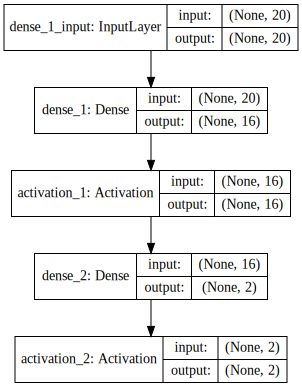

In [17]:
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

plot_model(model, to_file='model.png', show_shapes=True)
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

The final touch: declaring the loss function for the model. At a high-level, loss is the function that is minimized as our model trains. As loss decreases, we approach the ideal solution for our function. In this case, we've chosen the "categorical_crossentropy" function.

In [18]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

#### Train the model

We've taken a corpus of movie reviews which have been labeled by sentiment, converted both the sentences and labels into data our network understands, and designed a simple neural network. We're finally ready to train the model.

Start by defining a few hyperparameters: how fast and how long to train. 

In [19]:
batch_size = 32
epochs = 5

Asking Keras to train your model is done with the call <pre> model.fit </pre> See if you can identify each of the parameters in this call.

In [22]:
from keras.callbacks import TensorBoard  
tensorboard=TensorBoard(log_dir='./logs', write_graph=True, write_images=True)
from keras.callbacks import EarlyStopping  
early_stopping=EarlyStopping(monitor='val_loss')  


history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[tensorboard, early_stopping])

Train on 7689 samples, validate on 855 samples
Epoch 1/5
7689/7689 [==============================] - 5s 641us/step - loss: 0.3018 - acc: 0.8857 - val_loss: 0.1263 - val_acc: 1.0000
Epoch 2/5
7689/7689 [==============================] - 1s 106us/step - loss: 0.0463 - acc: 0.9973 - val_loss: 0.0566 - val_acc: 1.0000
Epoch 3/5
7689/7689 [==============================] - 1s 110us/step - loss: 0.0300 - acc: 0.9973 - val_loss: 0.0352 - val_acc: 1.0000
Epoch 4/5
7689/7689 [==============================] - 1s 108us/step - loss: 0.0263 - acc: 0.9973 - val_loss: 0.0253 - val_acc: 1.0000
Epoch 5/5
7689/7689 [==============================] - 1s 159us/step - loss: 0.0248 - acc: 0.9973 - val_loss: 0.0199 - val_acc: 1.0000


In [23]:
results = model.predict(x_test, batch_size=batch_size, verbose=1)

2210/2210 [==============================] - 0s 34us/step


As expected, loss decreased during training. Our model was able to fit to the data over time. When in doubt, starting with a simple model and adding complexity is recommended. However, there are some workflows where we have more insight about where to start. Let's see if we can do better with recurrent neural networks, which are now the industry standard for NLP tasks.

### Models designed for natural language processing: RNNs

The simple network we trained in the last section was intentionally the simplest network we could have built. Without any insight as to where to start, starting simple is usually recommended. However, there are networks that are known to be particularly well matched for specific types of problems. 

An examination of [DL4J's great problem type to network type summary](https://deeplearning4j.org/neuralnetworktable) shows that for all text, sound, and time-series tasks are well matched for some form of Recurrent Networks (RNN, RNTN, etc.). The need for memory is the main characteristic that sets these networks apart.  **The nature of language is that each word is understood through the context of the words that came before it.**

In Recurrent Neural Networks (RNNs), the output of the network after each prediction becomes a part of the input of the next prediction. 

![](https://cdn-images-1.medium.com/max/759/1*UkI9za9zTR-HL8uM15Wmzw.png)

#### Data for an RNN

Planning to use the right type of network for the problem means that we're more likely to find datasets designed for our model. In this case, keras has a dataset called [IMDB](https://keras.io/datasets/#imdb-movie-reviews-sentiment-classification) which is tailor made to train sentiment classification models.

We can load the data below:

In [26]:
from keras.datasets import imdb
print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_words)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

Loading data...
17465344/17464789 [==============================] - 0s 0us/step
25000 train sequences
25000 test sequences


We need to pad (or trim) sentences to a maximum length, maxlen, so our RNN can work with them in batches.

In [27]:
from keras.preprocessing import sequence
print('Pad sequences (samples x time)')
maxlen = 80  # cut texts after this number of words (among top max_features most common words)
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Pad sequences (samples x time)
x_train shape: (25000, 80)
x_test shape: (25000, 80)


#### Layer types for recurrent networks

The ideal type of layer for this type of network is called a Long-Short Term Memory (LSTM) layer. LSTMs hold memory until something in the data indicates that it should be forgotten. For example, a model may learn that a period or end of paragraph is a signal to forget some aspects of the model. The math of an LSTM is below for those who are interested. 

## LSTM
Formulae:
![](https://wikimedia.org/api/rest_v1/media/math/render/svg/2db2cba6a0d878e13932fa27ce6f3fb71ad99cf1)


And on figure:
![](https://www.researchgate.net/profile/Marijn_Stollenga/publication/304346489/figure/fig13/AS:376211038588933@1466707109201/Figure-74-RNN-and-LSTM-A-graphical-representation-of-the-RNN-and-LSTM-networks-are.png)

### Building an RNN

To build an RNN, we don't need to know everything about the math of an LSTM. To build an RNN, we tell Keras to use them. 

In [28]:
from keras.layers import LSTM, Embedding

Now we introduce two new layers: ```Embedding``` - the layer which learns a vector for each word, and ```LSTM``` - which is just an LSTM cell described above.

In [29]:
print('Build model...')
model = Sequential()
model.add(Embedding(max_words, 128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

Build model...


In [30]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Run the following training cell for the number of epochs we have specified. This will take about 10 minutes to run.

In [32]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[tensorboard, early_stopping])

Train on 22500 samples, validate on 2500 samples
Epoch 1/5
22500/22500 [==============================] - 101s 5ms/step - loss: 0.6814 - acc: 0.5608 - val_loss: 0.6713 - val_acc: 0.5960
Epoch 2/5
22500/22500 [==============================] - 100s 4ms/step - loss: 0.6705 - acc: 0.5844 - val_loss: 0.6777 - val_acc: 0.5816


In [33]:
score, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

25000/25000 [==============================] - 26s 1ms/step
Test score: 0.67773174221
Test accuracy: 0.5764


### Exercise 1

The score is better, but not much. You can improve it dramatically by adding some layers or tweaking some hyperparameters. Be creative! Your goal is to reach 0.75 on this dataset, but it is not the maximum achievable limit, just a target with the time you have to complete this lab. 

Once we can do text classification then many identification tasks open up to apply the same approach on. One example is [MBTI][https://www.kaggle.com/datasnaek/mbti-type) where people's personalities can be divided into 16 different types. The dataset includes writing samples from each of the personality types. 

### Exercise 2

Take home exercise to use the kaggle dataset to see if people's personality can be discerned based on the online written samples.

But it's not possible to do the analysis of the whole document in one shot so it has to be broken down into small steps. The strategy we will employ is called *part of speech tagging* or simply *PoS-tagging*; which is a markup of a sentence by PoS for every word. These tags for every word can then be used for tasks such as *text classification* which we will do in this lab.

Now, let us import all the libraries to setup our text classification process. We will be utilizing Keras framework for convenience and utilities like numpy for ease of use. Run the following cell by clicking inside of it and pressing (**Shift + Enter**). This will bring in the proper libraries. 

We will start our Natural Language Processing (NLP) journey with classification, because while it is a basic step in understanding natural languages, it is still a very practical start. Once we can figure out the meaning of a word then more complex tasks are possible such as sentiment analysis. Knowing sentiment of the words are very useful and common for many industries. For example, online reviews or comments are a common way for any big company to track their public image and how customers feel about them. Or used by companies like [Bloomberg](https://www.cio.com.au/article/628705/bloomberg-big-move-machine-learning-open-source) to process live news or tweets for a fuller picture to make better investment decisions. 